# Derivation of dG(r), cG(r) and cG(r)-cG(r) time discretizations for an abstract ODE with Gauss-Lobatto/Gauss-Legendre quadrature and one temporal element

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
from IPython.display import Math, display

t, k = symbols("t k")
init_printing()

In [2]:
# Choosing some value for the timestep size to visualize the basis functions
_k = 0.5
_t = np.linspace(0., _k, 100)

In [3]:
# HELPER FUNCTIONS

# compute temporal basis functions from the roots
def compute_basis_functions(roots):
    basis = []
    for i in range(len(roots)):
        f = 1 + 0*Id(t)
        for j in range(len(roots)):
            if i != j:
                f = Mul(f,(t - roots[j]) / (roots[i] - roots[j])) 
        #basis.append(f)
        basis.append(expand(f))
    return basis

# transform roots from [-1, 1] to [0, k]
def transform_roots(roots):
    new_roots = []
    for root in roots:
        new_roots.append(k * (root + 1) / 2)
    return new_roots
        
# evaluate each basis functions at the time points
# optional: scale basis by basis_coeffs
def get_basis_values(basis, basis_coeffs=None):
    if basis_coeffs is None:
        basis_coeffs = np.ones((len(basis)))
    
    # evaluate basis function at time points
    vals = [np.zeros_like(_t) for _ in range(len(basis))]
    for n in range(len(basis)):
        for i in range(_t.shape[0]):
            vals[n][i] = basis_coeffs[n] * basis[n].evalf(subs={t: _t[i], k: _k})
    
    return vals

# get linear combination of basis vector values
def get_basis_lincomb(basis, basis_coeffs):
    vals = get_basis_values(basis, basis_coeffs)
    result = np.zeros_like(vals[0])
    for n in range(len(basis)):
        result += vals[n]
    return result

# plot each basis vector
def plot_basis(basis, title=None):
    basis_vals = get_basis_values(basis)
    
    for n in range(len(basis)):
        plt.plot(_t, basis_vals[n], label=rf"$\varphi_{{{n}}}$")

    plt.xlabel("t")
    plt.ylabel("f(t)")
    plt.legend()
    if title is not None:
        plt.title(title)
    plt.show()

## Gauss-Lobatto temporal FE basis from $r = 0$ to $r = 6$

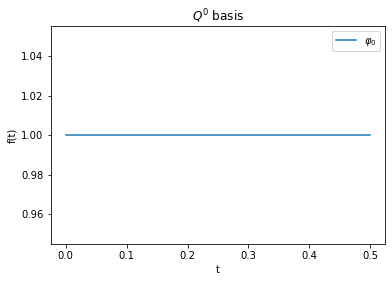

In [4]:
φ_0 = [1 + 0*Id(t)]
plot_basis(basis=φ_0, title=r"$Q^0$ basis")

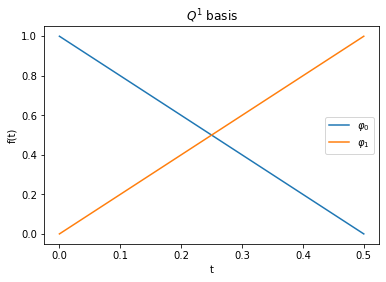

In [5]:
φ_1 = [1-t/k, t/k]
plot_basis(basis=φ_1, title=r"$Q^1$ basis")

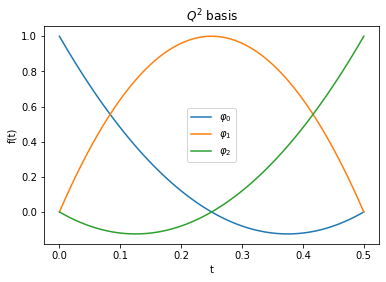

In [6]:
#φ_2 = [(2/k**2)*(t-k/2)*(t-k), -(4/k**2)*t*(t-k), (2/k**2)*t*(t-k/2)]
#φ_2 = compute_basis_functions([0, k / 2, k])
roots = [-1, 0, 1]
φ_2 = compute_basis_functions(transform_roots(roots))
plot_basis(basis=φ_2, title=r"$Q^2$ basis")

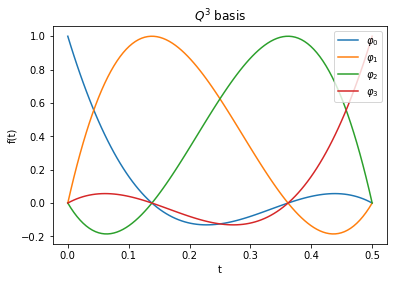

In [7]:
roots = [-1, -sqrt(Rational(1,5)), sqrt(Rational(1,5)), 1]
φ_3 = compute_basis_functions(transform_roots(roots))
#print(φ_3)
plot_basis(basis=φ_3, title=r"$Q^3$ basis")

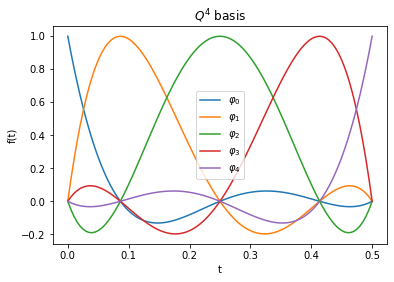

In [8]:
roots = [-1, -sqrt(Rational(3,7)), 0, sqrt(Rational(3,7)), 1]
φ_4 = compute_basis_functions(transform_roots(roots))
#print(φ_4)
plot_basis(basis=φ_4, title=r"$Q^4$ basis")

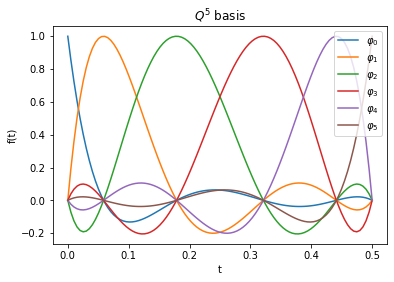

In [9]:
roots = [
    -1, 
    -sqrt(Rational(1,3)+sqrt(7)*Rational(2,21)), 
    -sqrt(Rational(1,3)-sqrt(7)*Rational(2,21)), 
     sqrt(Rational(1,3)-sqrt(7)*Rational(2,21)),
     sqrt(Rational(1,3)+sqrt(7)*Rational(2,21)), 
     1
]
#print([N(root) for root in roots])
φ_5 = compute_basis_functions(transform_roots(roots))
#print(φ_5)
plot_basis(basis=φ_5, title=r"$Q^5$ basis")

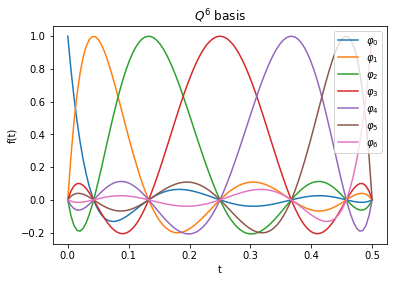

In [10]:
roots = [
    -1, 
    -sqrt(Rational(5,11)+sqrt(Rational(5,3))*Rational(2,11)), 
    -sqrt(Rational(5,11)-sqrt(Rational(5,3))*Rational(2,11)),
     0,
     sqrt(Rational(5,11)-sqrt(Rational(5,3))*Rational(2,11)),
     sqrt(Rational(5,11)+sqrt(Rational(5,3))*Rational(2,11)), 
     1
]
#print([N(root) for root in roots])
φ_6 = compute_basis_functions(transform_roots(roots))
#print(φ_6)
plot_basis(basis=φ_6, title=r"$Q^6$ basis")

In [11]:
# dictionary of temporal bases depending on the polynomial degree
φ = {0: φ_0, 1: φ_1, 2: φ_2, 3: φ_3, 4: φ_4, 5: φ_5, 6: φ_6}

## Temporal FE basis from $r = 7$ to $r = 10$

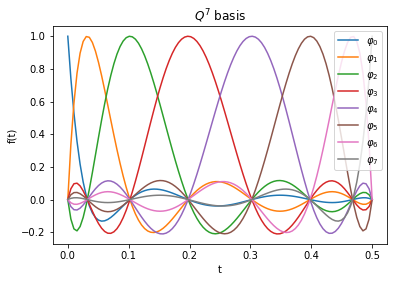

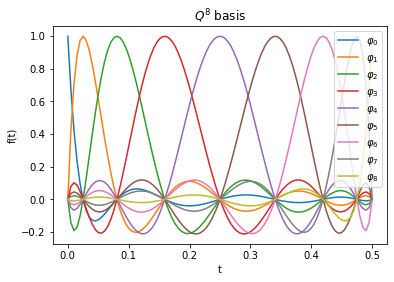

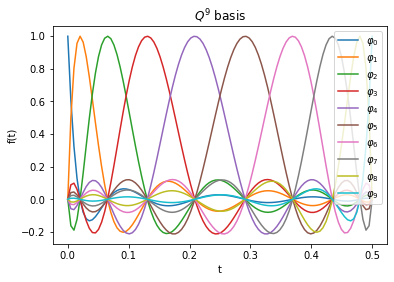

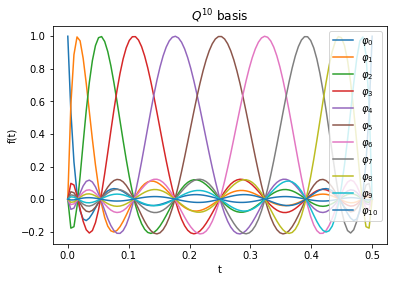

In [12]:
# compute basis up to Q^10 using orthopy to get approximate roots / Gauss-Lobatto quadrature points
import quadpy # INSTALLATION: 'conda install -c conda-forge quadpy' OR 'pip install quadpy'
for r in range(7, 11):
    φ[r] = compute_basis_functions(transform_roots(quadpy.c1.gauss_lobatto(r+1).points))
    
# plot basis for Q^7 to Q^10
for r in range(7, 11):
    plot_basis(basis=φ[r], title=rf"$Q^{{{r}}}$ basis")

## Assemble temporal matrices for dG(r)
We assemble the temporal matrices
$$
\begin{align}
M_k &= \left\{ \int_{I_m}\varphi_k^{(j)}\cdot \varphi_k^{(i)}\ \mathrm{d}t \right\}_{i,j = 1}^{r+1}, \\
B_k &= \left\{ \int_{I_m}\partial_t\varphi_k^{(j)}\cdot \varphi_k^{(i)}\ \mathrm{d}t \right\}_{i,j = 1}^{r+1}.
\end{align}
$$

In [13]:
def assemble_dGr_matrices(r):
    φ_r = φ[r]
    # initialize matrices
    matrix_M = [] # M_k
    matrix_B = [] # B_k
    for n in range(len(φ_r)):
        matrix_M.append([0.]*len(φ_r))
        matrix_B.append([0.]*len(φ_r))

    # assemble matrices (for dG(r) there are r+1 DoFs per element)
    for i in range(r+1):
        for j in range(r+1):
            matrix_M[i][j] = integrate( φ_r[j] * φ_r[i], (t, 0, k) )
            matrix_B[i][j] = integrate( diff(φ_r[j], t) * φ_r[i], (t, 0, k) )
            
            if r <= 4:
                # simplify matrix entries
                matrix_M[i][j] = simplify(matrix_M[i][j] / k)
                matrix_B[i][j] = simplify(matrix_B[i][j])
            else:
                # approximate matrix entries
                matrix_M[i][j] = N(matrix_M[i][j] / k).round(5)
                matrix_B[i][j] = N(matrix_B[i][j]).round(5)
    return matrix_M, matrix_B

# helper function
def common_divisor_matrix(matrix):
    denominators = [1]
    # find a common denominator for matrix
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            for op in str(matrix[i][j]).split(" "):
                if "/" in op:
                    denominators.append(int(op.split("/")[1]))
    divisor = lcm(set(denominators))
    
    # multiply matrix by divisor
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            matrix[i][j] *= divisor
    return divisor, matrix

for r in range(5): #range(11):
    print("--------------")
    print(f"|   r = {r}   |")
    print("--------------")
    matrix_M, matrix_B = assemble_dGr_matrices(r=r) 

    # NOTE: Don't forget adding initial condition to matrix_B, i.e. matrix_B[0][0] += 1
    # Now matrix_B = B_k + D_k^1
    matrix_B[0][0] += 1

    # print linear system
    latex_row = lambda matrix, row: " & ".join([latex(entry) for entry in matrix[row]])
    latex_matrix = lambda matrix : r"\begin{pmatrix}" + r"\\".join([latex_row(matrix,i) for i in range(len(φ[r]))]) + r"\end{pmatrix}"
    
    if r <= 4:
        # prettify matrix output
        divisor_B, matrix_B = common_divisor_matrix(matrix_B)
        display(Math(rf"B_k + D_k^1 = \frac{{{1}}}{{{divisor_B}}} " + latex_matrix(matrix_B)))
        print(rf"\frac{{{1}}}{{{divisor_B}}} \cdot " + latex_matrix(matrix_B))
        
        divisor_M, matrix_M = common_divisor_matrix(matrix_M)
        display(Math(rf"M_k = \frac{{k}}{{{divisor_M}}} " + latex_matrix(matrix_M)))
        print(rf"\frac{{k}}{{{divisor_M}}} \cdot " + latex_matrix(matrix_M))
    else:
        display(Math(r"B_k + D_k^1 = " + latex_matrix(matrix_B)))
        print(latex_matrix(matrix_B))
        display(Math(r"M_k = k " + latex_matrix(matrix_M)))
        print(latex_matrix(matrix_M))

--------------
|   r = 0   |
--------------


<IPython.core.display.Math object>

\frac{1}{1} \cdot \begin{pmatrix}1\end{pmatrix}


<IPython.core.display.Math object>

\frac{k}{1} \cdot \begin{pmatrix}1\end{pmatrix}
--------------
|   r = 1   |
--------------


<IPython.core.display.Math object>

\frac{1}{2} \cdot \begin{pmatrix}1 & 1\\-1 & 1\end{pmatrix}


<IPython.core.display.Math object>

\frac{k}{6} \cdot \begin{pmatrix}2 & 1\\1 & 2\end{pmatrix}
--------------
|   r = 2   |
--------------


<IPython.core.display.Math object>

\frac{1}{6} \cdot \begin{pmatrix}3 & 4 & -1\\-4 & 0 & 4\\1 & -4 & 3\end{pmatrix}


<IPython.core.display.Math object>

\frac{k}{30} \cdot \begin{pmatrix}4 & 2 & -1\\2 & 16 & 2\\-1 & 2 & 4\end{pmatrix}
--------------
|   r = 3   |
--------------


<IPython.core.display.Math object>

\frac{1}{24} \cdot \begin{pmatrix}12 & 5 + 5 \sqrt{5} & 5 - 5 \sqrt{5} & 2\\- 5 \sqrt{5} - 5 & 0 & 10 \sqrt{5} & 5 - 5 \sqrt{5}\\-5 + 5 \sqrt{5} & - 10 \sqrt{5} & 0 & 5 + 5 \sqrt{5}\\-2 & -5 + 5 \sqrt{5} & - 5 \sqrt{5} - 5 & 12\end{pmatrix}


<IPython.core.display.Math object>

\frac{k}{84} \cdot \begin{pmatrix}6 & \sqrt{5} & - \sqrt{5} & 1\\\sqrt{5} & 30 & 5 & - \sqrt{5}\\- \sqrt{5} & 5 & 30 & \sqrt{5}\\1 & - \sqrt{5} & \sqrt{5} & 6\end{pmatrix}
--------------
|   r = 4   |
--------------


<IPython.core.display.Math object>

\frac{1}{1080} \cdot \begin{pmatrix}540 & 63 \sqrt{21} + 441 & -288 & 441 - 63 \sqrt{21} & -54\\-441 - 63 \sqrt{21} & 0 & 224 \sqrt{21} & - 98 \sqrt{21} & 441 - 63 \sqrt{21}\\288 & - 224 \sqrt{21} & 0 & 224 \sqrt{21} & -288\\-441 + 63 \sqrt{21} & 98 \sqrt{21} & - 224 \sqrt{21} & 0 & 63 \sqrt{21} + 441\\54 & -441 + 63 \sqrt{21} & 288 & -441 - 63 \sqrt{21} & 540\end{pmatrix}


<IPython.core.display.Math object>

\frac{k}{1620} \cdot \begin{pmatrix}72 & 21 & -24 & 21 & -9\\21 & 392 & 56 & -49 & 21\\-24 & 56 & 512 & 56 & -24\\21 & -49 & 56 & 392 & 21\\-9 & 21 & -24 & 21 & 72\end{pmatrix}


## Assemble temporal matrices for cG(r)
We assemble the temporal matrices
$$
\begin{align}
    M_k &= \left\{ \int_{I_m}\varphi_k^{cG, (j)}\cdot \varphi_k^{dG, (i)}\ \mathrm{d}t \right\}_{i,j = 1}^{r,r+1}, \\
    B_k &= \left\{ \int_{I_m}\partial_t\varphi_k^{cG, (j)}\cdot \varphi_k^{dG, (i)}\ \mathrm{d}t \right\}_{i,j = 1}^{r,r+1}.
\end{align}
$$
Note that the dG basis functions are one degree lower, i.e. for $cG(r)$ we use $cG(r)$ trial and $dG(r)$ test functions.

In [14]:
def assemble_cGr_matrices(r):
    φ_r = φ[r] # trial functions
    ψ_r = φ[r-1] # test functions
    # initialize matrices
    matrix_M = [] # M_k
    matrix_B = [] # B_k
    for n in range(len(ψ_r)):
        matrix_M.append([0.]*len(φ_r))
        matrix_B.append([0.]*len(φ_r))

    # assemble matrices (for Q^r there are r+1 DoFs per element and for Q^{r-1} there are r DoFs)
    for i in range(r):
        for j in range(r+1):
            matrix_M[i][j] = integrate( φ_r[j] * ψ_r[i], (t, 0, k) )
            matrix_B[i][j] = integrate( diff(φ_r[j], t) * ψ_r[i], (t, 0, k) )
            
            if r <= 4:
                # simplify matrix entries
                matrix_M[i][j] = simplify(matrix_M[i][j] / k)
                matrix_B[i][j] = simplify(matrix_B[i][j])
            else:
                # approximate matrix entries
                matrix_M[i][j] = N(matrix_M[i][j] / k).round(5)
                matrix_B[i][j] = N(matrix_B[i][j]).round(5)
    return matrix_M, matrix_B

# helper function
def common_divisor_matrix(matrix):
    denominators = [1]
    # find a common denominator for matrix
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            for op in str(matrix[i][j]).split(" "):
                if "/" in op:
                    denominators.append(int(op.split("/")[1]))
    divisor = lcm(set(denominators))
    
    # multiply matrix by divisor
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            matrix[i][j] *= divisor
    return divisor, matrix

for r in range(1, 5): #range(1, 11):
    print("--------------")
    print(f"|   r = {r}   |")
    print("--------------")
    matrix_M, matrix_B = assemble_cGr_matrices(r=r) 

    # print linear system
    latex_row = lambda matrix, row: " & ".join([latex(entry) for entry in matrix[row]])
    latex_matrix = lambda matrix : r"\begin{pmatrix}" + r"\\".join([latex_row(matrix,i) for i in range(len(φ[r-1]))]) + r"\end{pmatrix}"
    
    if r <= 4:
        # prettify matrix output
        divisor_B, matrix_B = common_divisor_matrix(matrix_B)
        display(Math(rf"B_k = \frac{{{1}}}{{{divisor_B}}} " + latex_matrix(matrix_B)))
        print(rf"\frac{{{1}}}{{{divisor_B}}} " + latex_matrix(matrix_B))
        
        divisor_M, matrix_M = common_divisor_matrix(matrix_M)
        display(Math(rf"M_k = \frac{{k}}{{{divisor_M}}} " + latex_matrix(matrix_M)))
        print(rf"\frac{{k}}{{{divisor_M}}} " + latex_matrix(matrix_M))
    else:
        display(Math(r"B_k = " + latex_matrix(matrix_B)))
        print(latex_matrix(matrix_B))
        display(Math(r"M_k = k " + latex_matrix(matrix_M)))
        print(latex_matrix(matrix_M))

--------------
|   r = 1   |
--------------


<IPython.core.display.Math object>

\frac{1}{1} \begin{pmatrix}-1 & 1\end{pmatrix}


<IPython.core.display.Math object>

\frac{k}{2} \begin{pmatrix}1 & 1\end{pmatrix}
--------------
|   r = 2   |
--------------


<IPython.core.display.Math object>

\frac{1}{6} \begin{pmatrix}-5 & 4 & 1\\-1 & -4 & 5\end{pmatrix}


<IPython.core.display.Math object>

\frac{k}{6} \begin{pmatrix}1 & 2 & 0\\0 & 2 & 1\end{pmatrix}
--------------
|   r = 3   |
--------------


<IPython.core.display.Math object>

\frac{1}{12} \begin{pmatrix}-9 & 2 \sqrt{5} + 5 & 5 - 2 \sqrt{5} & -1\\-4 & - 4 \sqrt{5} & 4 \sqrt{5} & 4\\1 & -5 + 2 \sqrt{5} & -5 - 2 \sqrt{5} & 9\end{pmatrix}


<IPython.core.display.Math object>

\frac{k}{24} \begin{pmatrix}2 & 1 + \sqrt{5} & 1 - \sqrt{5} & 0\\0 & 8 & 8 & 0\\0 & 1 - \sqrt{5} & 1 + \sqrt{5} & 2\end{pmatrix}
--------------
|   r = 4   |
--------------


<IPython.core.display.Math object>

\frac{1}{360} \begin{pmatrix}-252 & 133 + 35 \sqrt{21} & -32 & 133 - 35 \sqrt{21} & 18\\- 45 \sqrt{5} - 45 & - 35 \sqrt{21} - 35 \sqrt{5} & 160 \sqrt{5} & - 35 \sqrt{5} + 35 \sqrt{21} & 45 - 45 \sqrt{5}\\-45 + 45 \sqrt{5} & - 35 \sqrt{21} + 35 \sqrt{5} & - 160 \sqrt{5} & 35 \sqrt{5} + 35 \sqrt{21} & 45 + 45 \sqrt{5}\\-18 & -133 + 35 \sqrt{21} & 32 & - 35 \sqrt{21} - 133 & 252\end{pmatrix}


<IPython.core.display.Math object>

\frac{k}{360} \begin{pmatrix}18 & 2 \sqrt{21} + 14 & -16 & 14 - 2 \sqrt{21} & 0\\0 & 35 + 5 \sqrt{105} & 80 & 35 - 5 \sqrt{105} & 0\\0 & 35 - 5 \sqrt{105} & 80 & 35 + 5 \sqrt{105} & 0\\0 & 14 - 2 \sqrt{21} & -16 & 2 \sqrt{21} + 14 & 18\end{pmatrix}


## Assemble temporal matrices for cG(r)-cG(r)
We assemble the temporal matrices
$$
\begin{align}
    M_k &= \left\{ \int_{I_m}\varphi_k^{(j)}\cdot \varphi_k^{(i)}\ \mathrm{d}t \right\}_{i,j = 1}^{r+1}, \\
    B_k &= \left\{ \int_{I_m}\partial_t\varphi_k^{(j)}\cdot \varphi_k^{(i)}\ \mathrm{d}t \right\}_{i,j = 1}^{r+1}.
\end{align}
$$
Then we clearly the first row of the matrices by enforcing the initial condition.

In [15]:
def assemble_cGr_cGr_matrices(r):
    φ_r = φ[r]
    # initialize matrices
    matrix_M = [] # M_k
    matrix_B = [] # B_k
    for n in range(len(φ_r)):
        matrix_M.append([0.]*len(φ_r))
        matrix_B.append([0.]*len(φ_r))

    # assemble matrices (for Q^r there are r+1 DoFs per element)
    for i in range(r+1):
        for j in range(r+1):
            matrix_M[i][j] = integrate( φ_r[j] * φ_r[i], (t, 0, k) )
            matrix_B[i][j] = integrate( diff(φ_r[j], t) * φ_r[i], (t, 0, k) )
            
            if r <= 4:
                # simplify matrix entries
                matrix_M[i][j] = simplify(matrix_M[i][j] / k)
                matrix_B[i][j] = simplify(matrix_B[i][j])
            else:
                # approximate matrix entries
                matrix_M[i][j] = N(matrix_M[i][j] / k).round(5)
                matrix_B[i][j] = N(matrix_B[i][j]).round(5)
    return matrix_M, matrix_B

# helper function
def common_divisor_matrix(matrix):
    denominators = [1]
    # find a common denominator for matrix
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            for op in str(matrix[i][j]).split(" "):
                if "/" in op:
                    denominators.append(int(op.split("/")[1]))
    divisor = lcm(set(denominators))
    
    # multiply matrix by divisor
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            matrix[i][j] *= divisor
    return divisor, matrix

def enforce_initial_condition(matrix, first_value=0.):
    # initialize matrix
    new_matrix= []
    for n in range(len(matrix)):
        new_matrix.append([0.]*len(matrix[n]))
    new_matrix[0][0] = first_value    
        
    # copy everything starting at the SECOND row
    for i in range(1,len(matrix)):
        for j in range(len(matrix[i])):
            new_matrix[i][j] = matrix[i][j]
    return new_matrix

for r in range(1, 5): #range(1, 11):
    print("--------------")
    print(f"|   r = {r}   |")
    print("--------------")
    matrix_M, matrix_B = assemble_cGr_cGr_matrices(r=r)
    matrix_M = enforce_initial_condition(matrix_M, first_value=0)
    matrix_B = enforce_initial_condition(matrix_B, first_value=1)
    

    # print linear system
    latex_row = lambda matrix, row: " & ".join([latex(entry) for entry in matrix[row]])
    latex_matrix = lambda matrix : r"\begin{pmatrix}" + r"\\".join([latex_row(matrix,i) for i in range(len(φ[r]))]) + r"\end{pmatrix}"
    
    if r <= 4:
        # prettify matrix output
        divisor_B, matrix_B = common_divisor_matrix(matrix_B)
        display(Math(rf"B_k = \frac{{{1}}}{{{divisor_B}}} " + latex_matrix(matrix_B)))
        print(rf"\frac{{{1}}}{{{divisor_B}}} " + latex_matrix(matrix_B))
        
        divisor_M, matrix_M = common_divisor_matrix(matrix_M)
        display(Math(rf"M_k = \frac{{k}}{{{divisor_M}}} " + latex_matrix(matrix_M)))
        print(rf"\frac{{k}}{{{divisor_M}}} " + latex_matrix(matrix_M))
    else:
        display(Math(r"B_k = " + latex_matrix(matrix_B)))
        print(latex_matrix(matrix_B))
        display(Math(r"M_k = k " + latex_matrix(matrix_M)))
        print(latex_matrix(matrix_M))

--------------
|   r = 1   |
--------------


<IPython.core.display.Math object>

\frac{1}{2} \begin{pmatrix}2 & 0\\-1 & 1\end{pmatrix}


<IPython.core.display.Math object>

\frac{k}{6} \begin{pmatrix}0 & 0\\1 & 2\end{pmatrix}
--------------
|   r = 2   |
--------------


<IPython.core.display.Math object>

\frac{1}{6} \begin{pmatrix}6 & 0 & 0\\-4 & 0 & 4\\1 & -4 & 3\end{pmatrix}


<IPython.core.display.Math object>

\frac{k}{30} \begin{pmatrix}0 & 0 & 0\\2 & 16 & 2\\-1 & 2 & 4\end{pmatrix}
--------------
|   r = 3   |
--------------


<IPython.core.display.Math object>

\frac{1}{24} \begin{pmatrix}24 & 0 & 0 & 0\\- 5 \sqrt{5} - 5 & 0 & 10 \sqrt{5} & 5 - 5 \sqrt{5}\\-5 + 5 \sqrt{5} & - 10 \sqrt{5} & 0 & 5 + 5 \sqrt{5}\\-2 & -5 + 5 \sqrt{5} & - 5 \sqrt{5} - 5 & 12\end{pmatrix}


<IPython.core.display.Math object>

\frac{k}{84} \begin{pmatrix}0 & 0 & 0 & 0\\\sqrt{5} & 30 & 5 & - \sqrt{5}\\- \sqrt{5} & 5 & 30 & \sqrt{5}\\1 & - \sqrt{5} & \sqrt{5} & 6\end{pmatrix}
--------------
|   r = 4   |
--------------


<IPython.core.display.Math object>

\frac{1}{1080} \begin{pmatrix}1080 & 0 & 0 & 0 & 0\\-441 - 63 \sqrt{21} & 0 & 224 \sqrt{21} & - 98 \sqrt{21} & 441 - 63 \sqrt{21}\\288 & - 224 \sqrt{21} & 0 & 224 \sqrt{21} & -288\\-441 + 63 \sqrt{21} & 98 \sqrt{21} & - 224 \sqrt{21} & 0 & 63 \sqrt{21} + 441\\54 & -441 + 63 \sqrt{21} & 288 & -441 - 63 \sqrt{21} & 540\end{pmatrix}


<IPython.core.display.Math object>

\frac{k}{1620} \begin{pmatrix}0 & 0 & 0 & 0 & 0\\21 & 392 & 56 & -49 & 21\\-24 & 56 & 512 & 56 & -24\\21 & -49 & 56 & 392 & 21\\-9 & 21 & -24 & 21 & 72\end{pmatrix}


## Gauss-Legendre temporal basis from $r = 1$ to $r = 6$

[k*(1 - sqrt(3)/3)/2, k*(sqrt(3)/3 + 1)/2]
[1/2 + sqrt(3)/2 - sqrt(3)*t/k, -sqrt(3)/2 + 1/2 + sqrt(3)*t/k]


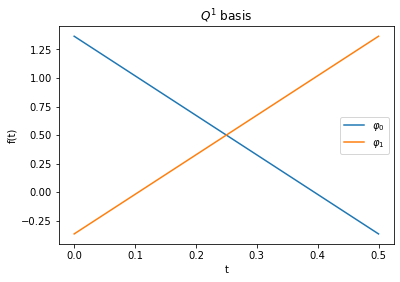

In [16]:
φ = {} # reset basis functions

roots = [-sqrt(Rational(1,3)), sqrt(Rational(1,3))] # Gauss-Legendre quadrature!
print(transform_roots(roots))
φ[1] = compute_basis_functions(transform_roots(roots))
print(φ[1])
plot_basis(basis=φ[1], title=r"$Q^1$ basis")

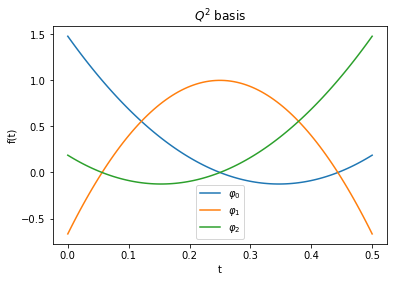

In [17]:
roots = [-sqrt(Rational(3,5)), 0, sqrt(Rational(3,5))]
φ[2] = compute_basis_functions(transform_roots(roots))
plot_basis(basis=φ[2], title=r"$Q^2$ basis")

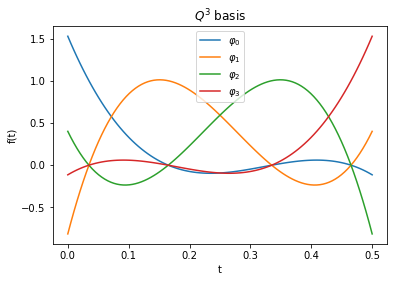

In [18]:
roots = [
    -sqrt(Rational(3,7) + Rational(2,7)*sqrt(Rational(6,5))), 
    -sqrt(Rational(3,7) - Rational(2,7)*sqrt(Rational(6,5))),
     sqrt(Rational(3,7) - Rational(2,7)*sqrt(Rational(6,5))),
     sqrt(Rational(3,7) + Rational(2,7)*sqrt(Rational(6,5))),
]
φ[3] = compute_basis_functions(transform_roots(roots))
plot_basis(basis=φ[3], title=r"$Q^3$ basis")

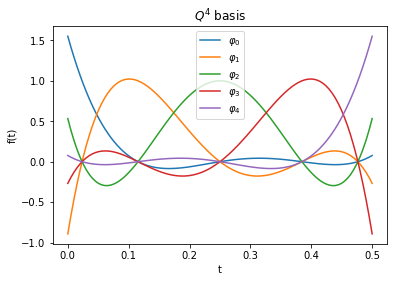

In [19]:
roots = [
    -Rational(1,3)*sqrt(5 + 2*sqrt(Rational(10,7))), 
    -Rational(1,3)*sqrt(5 - 2*sqrt(Rational(10,7))),
     0,
     Rational(1,3)*sqrt(5 - 2*sqrt(Rational(10,7))),
     Rational(1,3)*sqrt(5 + 2*sqrt(Rational(10,7))),
]
φ[4] = compute_basis_functions(transform_roots(roots))
plot_basis(basis=φ[4], title=r"$Q^4$ basis")

In [20]:
def assemble_dGr_Legendre_matrices(r):
    φ_r = φ[r]
    # initialize matrices
    matrix_M = [] # M_k
    matrix_B = [] # B_k
    matrix_D_new = [] # D_k^+
    matrix_D_old = [] # D_k^-
    for n in range(len(φ_r)):
        matrix_M.append([0.]*len(φ_r))
        matrix_B.append([0.]*len(φ_r))
        matrix_D_new.append([0.]*len(φ_r))
        matrix_D_old.append([0.]*len(φ_r))

    # assemble matrices (for dG(r) there are r+1 DoFs per element)
    for i in range(r+1):
        for j in range(r+1):
            matrix_M[i][j] = integrate( φ_r[j] * φ_r[i], (t, 0, k) )
            matrix_B[i][j] = integrate( diff(φ_r[j], t) * φ_r[i], (t, 0, k) )
            
            matrix_D_new[i][j] = φ_r[j].replace(t, 0) * φ_r[i].replace(t, 0)
            matrix_D_old[i][j] = φ_r[j].replace(t, k) * φ_r[i].replace(t, 0)
            
            # simplify matrix entries
            matrix_M[i][j] = simplify(matrix_M[i][j] / k)
            matrix_B[i][j] = simplify(matrix_B[i][j])
            matrix_D_new[i][j] = simplify(matrix_D_new[i][j])
            matrix_D_old[i][j] = simplify(matrix_D_old[i][j])
            
    return matrix_M, matrix_B, matrix_D_new, matrix_D_old

# helper function
def common_divisor_matrix(matrix):
    denominators = [1]
    # find a common denominator for matrix
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            for op in str(matrix[i][j]).split(" "):
                if "/" in op:
                    denominators.append(int(op.split("/")[1]))
    divisor = lcm(set(denominators))
    
    # multiply matrix by divisor
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            matrix[i][j] *= divisor
    return divisor, matrix

for r in range(1,3):
    print("--------------")
    print(f"|   r = {r}   |")
    print("--------------")
    matrix_M, matrix_B, matrix_D_new, matrix_D_old = assemble_dGr_Legendre_matrices(r=r) 
    
    # print linear system
    latex_row = lambda matrix, row: " & ".join([latex(entry) for entry in matrix[row]])
    latex_matrix = lambda matrix : r"\begin{pmatrix}" + r"\\".join([latex_row(matrix,i) for i in range(len(φ[r]))]) + r"\end{pmatrix}"

    # prettify matrix output
    """
    divisor_D_new = 1
    try:
        divisor_D_new, matrix_D_new = common_divisor_matrix(matrix_D_new)
    except:
        pass
    display(Math(rf"D_k^+ = \frac{{{1}}}{{{divisor_D_new}}} " + latex_matrix(matrix_D_new)))
    print(rf"\frac{{{1}}}{{{divisor_D_new}}} \cdot " + latex_matrix(matrix_D_new))

    _divisor_B = 1
    # make deepcopy of matrix_B -> only shallow copy?! watch out.
    _matrix_B = []
    for n in range(len(φ[r])):
        _matrix_B.append([0.]*len(φ[r]))
    for i in range(len(matrix_B)):
        for j in range(len(matrix_B[i])):
            _matrix_B[i][j] = matrix_B[i][j]
    try:
        _divisor_B, _matrix_B = common_divisor_matrix(_matrix_B)
    except:
        pass
    display(Math(rf"B_k = \frac{{{1}}}{{{_divisor_B}}} " + latex_matrix(_matrix_B)))
    print(rf"\frac{{{1}}}{{{_divisor_B}}} \cdot " + latex_matrix(_matrix_B))
    """
    
    for i in range(r+1):
        for j in range(r+1):
            matrix_B[i][j] += matrix_D_new[i][j]
            
    divisor_B = 1
    try:
        divisor_B, matrix_B = common_divisor_matrix(matrix_B)
    except:
        pass
    display(Math(rf"B_k + D_k^+ = \frac{{{1}}}{{{divisor_B}}} " + latex_matrix(matrix_B)))
    print(rf"\frac{{{1}}}{{{divisor_B}}} \cdot " + latex_matrix(matrix_B))
    
    divisor_M = 1
    try:
        divisor_M, matrix_M = common_divisor_matrix(matrix_M)
    except:
        pass
    display(Math(rf"M_k = \frac{{k}}{{{divisor_M}}} " + latex_matrix(matrix_M)))
    print(rf"\frac{{k}}{{{divisor_M}}} \cdot " + latex_matrix(matrix_M))
    
    divisor_D_old = 1
    try:
        divisor_D_old, matrix_D_old = common_divisor_matrix(matrix_D_old)
    except:
        pass
    display(Math(rf"D_k^- = \frac{{{1}}}{{{divisor_D_old}}} " + latex_matrix(matrix_D_old)))
    print(rf"\frac{{{1}}}{{{divisor_D_old}}} \cdot " + latex_matrix(matrix_D_old))


--------------
|   r = 1   |
--------------


<IPython.core.display.Math object>

\frac{1}{2} \cdot \begin{pmatrix}2 & -1 + \sqrt{3}\\- \sqrt{3} - 1 & 2\end{pmatrix}


<IPython.core.display.Math object>

\frac{k}{2} \cdot \begin{pmatrix}1 & 0\\0 & 1\end{pmatrix}


<IPython.core.display.Math object>

\frac{1}{2} \cdot \begin{pmatrix}-1 & \sqrt{3} + 2\\2 - \sqrt{3} & -1\end{pmatrix}
--------------
|   r = 2   |
--------------


<IPython.core.display.Math object>

\frac{1}{108} \cdot \begin{pmatrix}- 30 \sqrt{15} + 3 \left(\sqrt{15} + 5\right)^{2} & -60 + 28 \sqrt{15} & 30 - 10 \sqrt{15}\\- 28 \sqrt{15} - 60 & 48 & -60 + 28 \sqrt{15}\\30 + 10 \sqrt{15} & - 28 \sqrt{15} - 60 & 3 \left(5 - \sqrt{15}\right)^{2} + 30 \sqrt{15}\end{pmatrix}


<IPython.core.display.Math object>

\frac{k}{18} \cdot \begin{pmatrix}5 & 0 & 0\\0 & 8 & 0\\0 & 0 & 5\end{pmatrix}


<IPython.core.display.Math object>

\frac{1}{36} \cdot \begin{pmatrix}10 & -20 - 4 \sqrt{15} & \left(\sqrt{15} + 5\right)^{2}\\-20 + 4 \sqrt{15} & 16 & -20 - 4 \sqrt{15}\\\left(5 - \sqrt{15}\right)^{2} & -20 + 4 \sqrt{15} & 10\end{pmatrix}
